In [1]:
# ---------------------------------- Libraries ----------------------------------
!pip install -q transformers accelerate torch datasets peft trl openai scikit-learn gradio
!pip install -U huggingface_hub
!pip install -U bitsandbytes
!pip install --upgrade trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.8/503.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.0.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.1
    Uninstalling hugging

In [2]:

# ---------------------------------- Imports ----------------------------------
import bitsandbytes as bnb
from datasets import load_dataset, Dataset, DatasetDict
import gc
from google.colab import userdata
from huggingface_hub import create_repo, login, HfApi, notebook_login
from IPython.display import display, Markdown
import json
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
import torch
import trl
from tqdm.notebook import tqdm
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    BitsAndBytesConfig,
)
from trl import SFTTrainer


In [3]:
# ---------------------------------- HuggingFace Connection ----------------------------------
hf_token = os.environ.get('HF_TOKEN') or userdata.get('HF_TOKEN')

if hf_token:
    login(token=hf_token)
    print("HuggingFace login successful.")
else:
    print("HuggingFace token not found. Please set the HF_TOKEN environment variable or store it in Colab secrets.")

HuggingFace login successful.


In [4]:
# ---------------------------------- Use GPU ----------------------------------
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    # Set default device to GPU
    torch.set_default_device("cuda")
    print("PyTorch default device set to CUDA (GPU).")
else:
    print("WARNING: No GPU detected. Running on CPU")

GPU detected: NVIDIA A100-SXM4-40GB
PyTorch default device set to CUDA (GPU).


In [5]:
# ---------------------------------- Functions ----------------------------------
# Helper function for markdown display
def print_markdown(text):
    """Displays text as Markdown."""
    display(Markdown(text))



In [6]:
# ---------------------------------- Load Dataset ----------------------------------
# https://huggingface.co/datasets/Daniel-ML/sentiment-analysis-for-financial-news-v2/viewer
dataset_id = "Daniel-ML/sentiment-analysis-for-financial-news-v2"

# Load the data set
labeled_dataset = load_dataset(dataset_id, split = "train")
print("Dataset loaded successfully!")


README.md:   0%|          | 0.00/36.0 [00:00<?, ?B/s]

pd_df_json.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset loaded successfully!


In [7]:
# ---------------------------------- View Dataset ----------------------------------
# View the data set
print("\n--- Dataset Information ---")
print(labeled_dataset)

# View the dataset features
print("\n--- Dataset Features ---")
print(labeled_dataset.features)

# Unique Labels
labels = labeled_dataset.to_pandas()['sentiment'].unique().tolist()
print("\n--- Unique Labels ---")
print(f"Unique labels in the dataset: {labels}")


--- Dataset Information ---
Dataset({
    features: ['sentiment', 'text'],
    num_rows: 4846
})

--- Dataset Features ---
{'sentiment': Value('string'), 'text': Value('string')}

--- Unique Labels ---
Unique labels in the dataset: ['neutral', 'negative', 'positive']





--- Dataset Information ---  
Dataset({  
    features: ['sentiment', 'text'],  
    num_rows: 4846  
})  
  
--- Dataset Features ---  
{'sentiment': Value('string'), 'text': Value('string')}  
  
--- Unique Labels ---  
Unique labels in the dataset: ['neutral', 'negative', 'positive']  


In [8]:
# View the data as a python DataFrame
display(labeled_dataset.select(range(5)).to_pandas()[["text", "sentiment"]])

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


**text**  **sentiment**  
**0**  According to Gran , the company has no plans t...  neutral  
**1**  Technopolis plans to develop in stages an area...  neutral  
**2**  The international electronic industry company ...  negative  
**3**  With the new production plant the company woul...  positive  
**4**  According to the company 's updated strategy f...  positive  

In [9]:
# ---------------------------------- Split Dataset into Train / Test Dataset ----------------------------------
# Split the Data into Train and Test Sets ---
print("\nSplitting data into Train (90%) and Test (10%)...")
train_test_split_ratio = 0.10

# Set seed for reproducability
seed = 42

# Using datasets built-in method.  Shuffle the data to allow the LLM not learn the order of each sample.
split_dataset = labeled_dataset.train_test_split(
    test_size = train_test_split_ratio, seed = seed, shuffle = True,
)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print("\nTrain/Test Split Complete.")


Splitting data into Train (90%) and Test (10%)...
Training set size: 4361
Test set size: 485

Train/Test Split Complete.





Splitting data into Train (90%) and Test (10%)...  
Training set size: 4361  
Test set size: 485  
  
Train/Test Split Complete.  


<Axes: xlabel='count'>

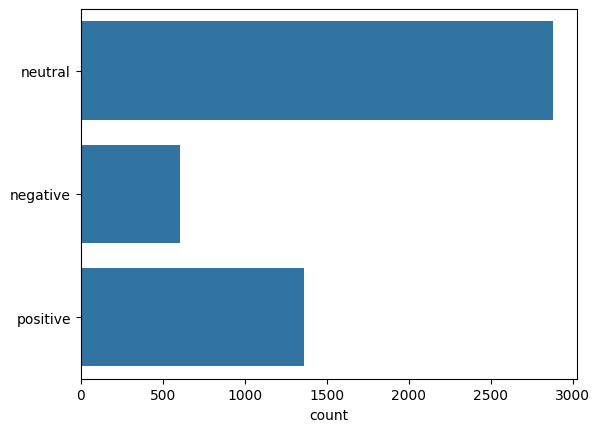

In [10]:
# ---------------------------------- View Dataset Balance ----------------------------------
sns.countplot(labeled_dataset["sentiment"])

If the dataset is balanced, the model may have a bias towards certain data.

In [11]:
# ---------------------------------- Format for Supervised Fine-Tuning ("google/gemma-3-1b-it") ----------------------------------
def format_for_sft_gemma(example, tokenizer):

    # Define the conversation structure
    system_prompt = "Classify the sentiment of the following sentence from News as positive, negative, or neutral."
    user_prompt = f"Sentence: {example['text']}"
    assistant_response = example['sentiment'] # The target label

    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"}, # Combine system/user for simplicity here
        {"role": "assistant", "content": assistant_response}
    ]
    # Apply the tokenizer's chat template.
    # tokenize = False: means we want the text output, not token IDs.
    # add_generation_prompt = False: means we’re NOT adding the assistant prompt to generate the response. We already provided the assistant's message
    formatted_text = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt = False)
    return {"text": formatted_text}

In [12]:
# ---------------------------------- Test the Supervised Fine-Tuning Function ("google/gemma-3-1b-it") ----------------------------------
os_model_id = "google/gemma-3-1b-it"

# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # Use 4-bit weights (saves lots of RAM)
    bnb_4bit_quant_type = "nf4", # nf4 is a better 4-bit format (Non-Float 4)
    bnb_4bit_compute_dtype = torch.float16 # Math is done in float16 for speed
)

# Load the tokenizer to convert text to tokens (numbers)
base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Set pad token if missing (Gemma often doesn't have one)
# A pad token is a special token used to make all input sequences the same length in a batch.
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [13]:
# ---------------------------------- Test Random Data ("google/gemma-3-1b-it") ----------------------------------
# Sample input dictionary
# <bos>                      → Beginning of sequence (tells the model: "Start reading")
# <start_of_turn>user        → Start of the user's turn
# Classify the sentiment...  → Instruction and user input
# <end_of_turn>              → End of user input
# <start_of_turn>model       → Start of the assistant/model's reply
# positive                   → The expected response
# <end_of_turn>              → End of assistant reply

example = {
    "text": "The economy is showing signs of recovery after a tough year.",
    "sentiment": "positive"
}

# Apply the formatting function
formatted_example = format_for_sft_gemma(example, base_os_tokenizer)

# Print the result
print("\n--- Sample Formatted Prompt ---")
print(formatted_example["text"])


--- Sample Formatted Prompt ---
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: The economy is showing signs of recovery after a tough year.<end_of_turn>
<start_of_turn>model
positive<end_of_turn>



In [14]:
# ---------------------------------- Format for Supervised Fine-Tuning ("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B") ----------------------------------
def format_for_sft_deepseek_qwen(example, tokenizer):
    # Target task
    system_prompt = "Classify the sentiment of the following sentence from News as positive, negative, or neutral."
    user_prompt = f"Sentence: {example['text']}"
    assistant_response = example['sentiment']  # gold label

    # Qwen-style roles (ChatML)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": user_prompt},
        {"role": "assistant", "content": assistant_response},
    ]

    # For SFT we want the full conversation (incl. assistant target) serialized as text
    # so we set tokenize=False and add_generation_prompt=False.
    formatted_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
    )
    return {"text": formatted_text}

In [15]:
# ---------------------------------- Test the Supervised Fine-Tuning Function ("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B") ----------------------------------
os_model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # Use 4-bit weights (saves lots of RAM)
    bnb_4bit_quant_type = "nf4", # nf4 is a better 4-bit format (Non-Float 4)
    bnb_4bit_compute_dtype = torch.float16 # Math is done in float16 for speed
)

# Load the tokenizer to convert text to tokens (numbers)
base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id)

# Set pad token if missing (Gemma often doesn't have one)
# A pad token is a special token used to make all input sequences the same length in a batch.
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token
    print(f"Set pad_token to eos_token ({base_os_tokenizer.eos_token})")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [16]:
# ---------------------------------- Test A Random Row ("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B") ----------------------------------
# Pick a random index
idx = random.randint(0, len(train_dataset) - 1)

# Retrieve that row
random_row = train_dataset[idx]

print(random_row)

example_2 = {
    "text": random_row['text'],
    "sentiment": random_row['sentiment']
}

# Apply the formatting function
formatted_example_2 = format_for_sft_deepseek_qwen(example_2, base_os_tokenizer)

# Print the result
print("\n--- Sample Formatted Prompt ---")
print(formatted_example_2["text"])

{'sentiment': 'positive', 'text': 'TeliaSonera said about $ 100 million will be invested in the next year in the region to bring mobile coverage to about 90 % of Nepal s population .'}

--- Sample Formatted Prompt ---
<｜begin▁of▁sentence｜>Classify the sentiment of the following sentence from News as positive, negative, or neutral.<｜User｜>Sentence: TeliaSonera said about $ 100 million will be invested in the next year in the region to bring mobile coverage to about 90 % of Nepal s population .<｜Assistant｜>positive<｜end▁of▁sentence｜>


In [17]:
# ---------------------------------- Zero Shot Classification ("google/gemma-3-1b-it") ----------------------------------
os_model_id = "google/gemma-3-1b-it"

base_os_tokenizer = AutoTokenizer.from_pretrained(os_model_id, use_fast=True)
if base_os_tokenizer.pad_token is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token

base_os_model = AutoModelForCausalLM.from_pretrained(
    os_model_id,
    device_map="auto",
    torch_dtype="auto",
    low_cpu_mem_usage=True,
)

base_os_model.config.pad_token_id = base_os_tokenizer.pad_token_id
print("Loaded Gemma-3 1B-IT without bnb 4-bit.")


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Loaded Gemma-3 1B-IT without bnb 4-bit.


In [18]:
# ---------------------------------- Apply Formatting for SFT Function to Test/Train Data ("google/gemma-3-1b-it") ----------------------------------
print("\nFormatting data for SFTTrainer (Gemma format)...")
sft_train_dataset = train_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(train_dataset.features)
              )
sft_test_dataset = test_dataset.map(
              format_for_sft_gemma,
              fn_kwargs={"tokenizer": base_os_tokenizer},
              remove_columns=list(test_dataset.features)
              )
print("SFTTrainer (Gemma) formatting complete.")
print("Sample SFT Gemma format:")
print(sft_train_dataset[0]['text'])


Formatting data for SFTTrainer (Gemma format)...


Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

SFTTrainer (Gemma) formatting complete.
Sample SFT Gemma format:
<bos><start_of_turn>user
Classify the sentiment of the following sentence from News as positive, negative, or neutral.
Sentence: These module products will be available for trials during 3Q-07 and for volume deliveries during 4Q-07 .<end_of_turn>
<start_of_turn>model
neutral<end_of_turn>



In [19]:
# ---------------------------------- Zero-Shot Classification Prompt Function ("google/gemma-3-1b-it") ----------------------------------
def create_zeroshot_prompt_gemma(sentence, tokenizer):

    """Creates zero-shot prompt using Gemma chat template."""
    system_prompt = f"Classify the sentiment of the following sentence from Financial News. Respond with ONLY ONE of the following labels: {', '.join(labels)}."
    user_prompt = f"Sentence: {sentence}"
    messages = [
        {"role": "user", "content": f"{system_prompt}\n{user_prompt}"},
    ]
    # Apply template, add_generation_prompt=True adds the assistant turn marker
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

In [20]:
# ---------------------------------- Inference Function for Zero-Shot Classification ("google/gemma-3-1b-it") ----------------------------------
# This function runs inference using the prompt generated above and returns the predicted sentiment label.
# It Gets the formatted prompt using the first function "create_zeroshot_prompt_gemma".
# It then tokenizes the prompt and sends it to the appropriate device (e.g., GPU):
def classify_zero_shot_os_gemma(sentence, model, tokenizer):

    prompt = create_zeroshot_prompt_gemma(sentence, tokenizer)
    inputs = tokenizer(prompt, return_tensors = "pt", truncation = True, max_length = 512).to(model.device)

    eos_id = tokenizer.eos_token_id          # eos_token_id: end of sentence
    pad_id = tokenizer.pad_token_id          # pad_token_id: padding token

    # Run the model to generate output, we are not performing gradient tracking since it's only inference!
    with torch.no_grad():

      outputs = model.generate(
          **inputs,
          max_new_tokens = 10, # Limits the number of tokens the model can generate
          eos_token_id = eos_id,
          pad_token_id = eos_id,
          do_sample = False
      )
    # Extracts and decode the generated text
    response_ids = outputs[0][inputs['input_ids'].shape[1]:]
    response_text = tokenizer.decode(response_ids, skip_special_tokens=True).strip()

    # print(f"Generated Text (Gemma): {response_text}")

    # Clean and Validate Output
    labels = ["neutral", "negative", "positive"]

    predicted_label = "Unknown"
    for label_text in labels:
        if label_text.lower() in response_text.lower(): # Simple check if label is present
              predicted_label = label_text
              break

    print(f"Predicted Label: {predicted_label}")
    return predicted_label


In [21]:
# ---------------------------------- Extract True Labels ("google/gemma-3-1b-it") ----------------------------------
true_labels = []

# Extract the ground truth (target output) which represents the True class
true_labels = [ex['sentiment'] for ex in test_dataset]
true_labels

['neutral',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 '

In [22]:
# ---------------------------------- Evaluate on Test Set ("google/gemma-3-1b-it") ----------------------------------
base_os_predictions = [] # Renaming for clarity if needed, but reusing is fine

# Invoke the pre-trained Gemma LLM on all testing datasets
for example in tqdm(test_dataset):
    predicted_label = classify_zero_shot_os_gemma(example['text'], base_os_model, base_os_tokenizer)
    base_os_predictions.append(predicted_label)

  0%|          | 0/485 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Predicted Label: positive
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: negative
Predicted Label: neutral
Predicted Label: negative
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: negative
Predicted Label: positive
Predicted Label: neutral
Predicted Label: positive
Predicted Label: neutral
Predicted Label: negative
Predicted Label: negative
Predicted Label: positive
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: positive
Predicted Label: positive
Predicted Label: neutral
Predicted Label: neutral
Predicted Label: negative
Predicted Label: neutral
Predi

In [23]:
# ---------------------------------- Examine Zero-Shot Evaluation Results ("google/gemma-3-1b-it") ----------------------------------
valid_indices = [i for i, p in enumerate(base_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds = [base_os_predictions[i] for i in valid_indices]
filtered_true = [true_labels[i] for i in valid_indices]

accuracy = accuracy_score(filtered_true, filtered_preds)
report = classification_report(filtered_true, filtered_preds, labels=labels, zero_division=0, target_names=labels)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)


Accuracy: 0.6598

Classification Report:
              precision    recall  f1-score   support

     neutral       0.83      0.59      0.69       290
    negative       0.51      0.91      0.65        56
    positive       0.55      0.71      0.62       139

    accuracy                           0.66       485
   macro avg       0.63      0.74      0.65       485
weighted avg       0.71      0.66      0.66       485



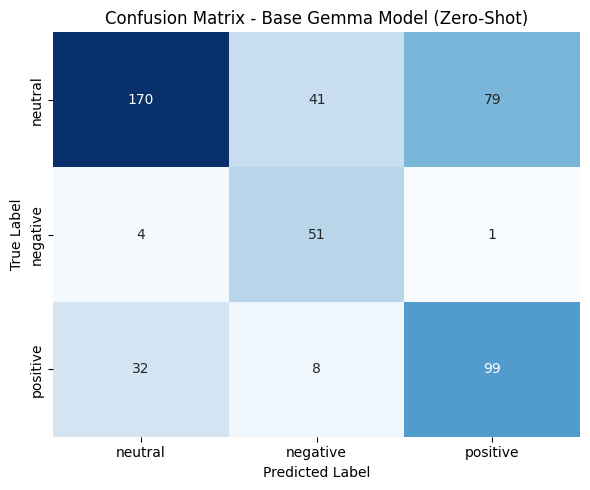

In [24]:
# ---------------------------------- Visualize Confusion Matrix ("google/gemma-3-1b-it") ----------------------------------
# Compute confusion matrix
cm = confusion_matrix(filtered_true, filtered_preds, labels=labels)

# Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Base Gemma Model (Zero-Shot)")
plt.tight_layout()
plt.show()

# This confusion matrix shows that the model wasn't the best at predicting the true classification

In [25]:
# ---------------------------------- LoRA ----------------------------------
# --- Prepare model for k-bit training (important for quantized models) ---
base_os_model.gradient_checkpointing_enable()  # Saves memory during training
prepared_model = prepare_model_for_kbit_training(base_os_model)
print("Model prepared for k-bit training.")

print(prepared_model)


# --- LoRA Configuration ---
# Target modules often include query/key/value layers in self-attention blocks
# This depends on the model architecture (use print(prepared_model) to inspect layers)
# For Qwen-based models, common targets might be 'q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'
# Let's start with a reasonable default set
lora_config = LoraConfig(
    r = 16,  # LoRA rank (dimension of adapter matrices). Higher rank = more parameters, potentially better fit but slower. 8, 16, 32 are common.
    lora_alpha = 32,  # Scaling factor for LoRA weights (often 2*r).
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],  # Modules to apply LoRA to.
    lora_dropout = 0.05,  # Dropout probability for LoRA layers.
    bias = "none",  # Usually set to 'none'.
    task_type = "CAUSAL_LM",  # Task type for sequence generation.
)
print("LoRA Config created.")

# --- Apply PEFT to the model ---
# This adds the small LoRA layers into the big model. During fine-tuning, only these are updated — saving a lot of compute and memory
peft_model = get_peft_model(prepared_model, lora_config)



# The percentage (often < 1%) is small because LoRA only introduces and trains the parameters within the small adapter layers (`q_proj`, `k_proj`, etc. in our config),
# It does not train the original billions of parameters in the base model (which remain frozen).
# Training far fewer parameters requires significantly less GPU memory (VRAM), making it feasible to fine-tune large models on hardware like Colab's T4 GPU.
# It's also much faster than full fine-tuning.
print("PEFT model created.")
peft_model.print_trainable_parameters()  # See how few parameters we're actually training!


Model prepared for k-bit training.
Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear(in_features=6912, out_features=1152, bias=False)
          (act_fn): GELUTanh()
        )
        (input_l

In [28]:
# ---------------------------------- Training Arguments ----------------------------------
output_dir = "./sentiment_finetuned_adapter"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=25,
    save_strategy="epoch",
    # optim="paged_adamw_8bit",
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    report_to="none",
    dataloader_pin_memory=False,   # avoid pinning CUDA tensors
    dataloader_num_workers=0,      # simplest/safer for Colab-style envs
)

print("Training Arguments set.")

# ---------------- Safety: ensure tokenizer & model padding are set ----------------
if getattr(base_os_tokenizer, "pad_token", None) is None:
    base_os_tokenizer.pad_token = base_os_tokenizer.eos_token

if hasattr(peft_model, "config"):
    peft_model.config.pad_token_id = base_os_tokenizer.pad_token_id
    peft_model.config.eos_token_id = base_os_tokenizer.eos_token_id
    if getattr(peft_model.config, "use_cache", None) is not None:
        peft_model.config.use_cache = False

# ---------------- Build a text-only data collator ----------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=base_os_tokenizer,
    mlm=False
)

# ---------------- Prepare / normalize the dataset ----------------
TEXT_COL = "text"  # change if your column is different

# 1) If it's a DatasetDict, pick the train split
if isinstance(sft_train_dataset, DatasetDict):
    if "train" not in sft_train_dataset:
        raise ValueError(f"DatasetDict has splits {list(sft_train_dataset.keys())}, but no 'train' split.")
    sft_train_dataset = sft_train_dataset["train"]

# 2) If it's a list of dicts, wrap it
if not hasattr(sft_train_dataset, "column_names"):
    sft_train_dataset = Dataset.from_list(sft_train_dataset)

assert TEXT_COL in sft_train_dataset.column_names, f"Expected '{TEXT_COL}' column in dataset; found {sft_train_dataset.column_names}"
assert len(sft_train_dataset) > 0, "Train dataset is empty."

# ---------------- Tokenize ----------------
MAX_LEN = 2048  # adjust to your context window & memory

def _tok_fn(batch):
    # Return CPU-side lists; collator will create tensors and pad dynamically
    return base_os_tokenizer(
        batch[TEXT_COL],
        truncation=True,
        max_length=MAX_LEN,
        padding=False,
        return_attention_mask=True
    )

tokenized_train = sft_train_dataset.map(
    _tok_fn,
    batched=True,
    remove_columns=sft_train_dataset.column_names  # drop raw text + other cols
)

# Reset any prior "torch" formatting or CUDA device formatting on the dataset
# so that we yield CPU-native python lists to the collator.
if hasattr(tokenized_train, "set_format"):
    tokenized_train.set_format(type=None)

# Sanity checks
required_cols = {"input_ids", "attention_mask"}
missing = required_cols.difference(set(tokenized_train.column_names))
if missing:
    raise ValueError(f"Tokenized dataset missing columns: {missing}. Columns present: {tokenized_train.column_names}")
if len(tokenized_train) == 0:
    raise ValueError("Tokenized train dataset is empty after mapping.")

print(f"Tokenized train samples: {len(tokenized_train)}")

# ---------------- Initialize vanilla HF Trainer (no TRL) ----------------
from transformers import Trainer # Import Trainer class

trainer = Trainer(
    model=peft_model,                    # LoRA-wrapped model
    args=training_args,
    train_dataset=tokenized_train,       # <-- ensure this is a Dataset, not DatasetDict
    tokenizer=base_os_tokenizer,         # OK despite deprecation; HF 5.x will prefer processing_class
    data_collator=data_collator,
)

print("Trainer initialized (no SFTTrainer, no AutoProcessor).")

# ---------------- Train ----------------
print("\n--- Starting Fine-tuning... ---")
try:
    training_results = trainer.train()
    print("--- Fine-tuning Complete! ---")
    print(training_results)

    # --- Save the LoRA Adapter + tokenizer ---
    print(f"Saving LoRA adapter model to {output_dir}...")
    trainer.save_model(output_dir)           # Saves adapter weights for PEFT-wrapped model
    base_os_tokenizer.save_pretrained(output_dir)
    print("Adapter and tokenizer saved.")

    # --- Clean up memory ---
    del trainer
    del peft_model
    torch.cuda.empty_cache()
    gc.collect()
    print("Cleaned up training objects from memory.")

    fine_tuning_successful = True

except Exception as e:
    print(f"Error during fine-tuning: {e}")
    fine_tuning_successful = False

Training Arguments set.


Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

/tmp/ipython-input-96470199.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


Tokenized train samples: 4361
Trainer initialized (no SFTTrainer, no AutoProcessor).

--- Starting Fine-tuning... ---


Step,Training Loss
25,5.095500
50,3.316700
75,2.436200
100,2.364200
125,2.204400
150,2.172200
175,1.987700
200,1.834800
225,1.841800
250,1.816200


--- Fine-tuning Complete! ---
TrainOutput(global_step=1638, training_loss=1.7805529805184575, metrics={'train_runtime': 1150.052, 'train_samples_per_second': 11.376, 'train_steps_per_second': 1.424, 'total_flos': 4472756380624896.0, 'train_loss': 1.7805529805184575, 'epoch': 3.0})
Saving LoRA adapter model to ./sentiment_finetuned_adapter...
Adapter and tokenizer saved.
Cleaned up training objects from memory.


In [29]:
# ---------------------------------- Push to HuggingFace ----------------------------------
from huggingface_hub import create_repo, HfApi, HfFolder

!huggingface-cli login

model_name = "gemma-sentiment-lora"
username = "david125tran"

# Create or get your repo (won’t error if it already exists)
repo_id = f"{username}/{model_name}"
create_repo(repo_id, private=False, exist_ok=True)

# Push the LoRA adapter + tokenizer folder
api = HfApi()
api.upload_folder(
    folder_path="./sentiment_finetuned_adapter",  # where your adapter and tokenizer are saved
    repo_id=repo_id,
    commit_message="Upload Gemma 3B sentiment LoRA adapter 🎉",
)

print(f"✅ Successfully uploaded! View it here: https://huggingface.co/{repo_id}")


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...point-1638/tokenizer.json:   1%|1         |  469kB / 33.4MB            

  ...point-1092/tokenizer.json:   1%|1         |  469kB / 33.4MB            

  ...oint-1092/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...point-546/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...oint-1638/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...ckpoint-546/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  ...ckpoint-1092/optimizer.pt:   0%|          | 25.2kB / 24.0MB            

  ...ckpoint-1638/optimizer.pt:   0%|          | 25.2kB / 24.0MB            

  ...ed_adapter/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...kpoint-546/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

✅ Successfully uploaded! View it here: https://huggingface.co/david125tran/gemma-sentiment-lora


In [30]:
# ---------------------------------- Evaluate Model ----------------------------------
# ==== Config you may tweak ====
os_model_id = os_model_id  # e.g. "google/gemma-3-1b-it"
adapter_path = "./sentiment_finetuned_adapter"
TEXT_COL = "text"
labels = labels

# ==== Imports ====
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from peft import PeftModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# --------- Helper: pick best available quantization/backend ---------
def build_base_model(model_id: str):
    has_cuda = torch.cuda.is_available()
    # try 4-bit
    if has_cuda:
        try:
            import bitsandbytes as bnb  # noqa: F401
            qconf = BitsAndBytesConfig(load_in_4bit=True)
            print("Loading base model in 4-bit quantization…")
            return AutoModelForCausalLM.from_pretrained(
                model_id,
                quantization_config=qconf,
                device_map="auto",
                trust_remote_code=True,
            )
        except Exception as e:
            print(f"⚠️ 4-bit load failed: {e}")
            # try 8-bit
            try:
                print("Falling back to 8-bit quantization…")
                qconf = BitsAndBytesConfig(load_in_8bit=True)
                return AutoModelForCausalLM.from_pretrained(
                    model_id,
                    quantization_config=qconf,
                    device_map="auto",
                    trust_remote_code=True,
                )
            except Exception as e2:
                print(f"⚠️ 8-bit load failed: {e2}")

    # final fallback: full precision (bf16 if supported, else fp16/cpu)
    dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else (torch.float16 if has_cuda else torch.float32)
    device_map = "auto" if has_cuda else None
    print(f"Falling back to full precision dtype={dtype} (device_map={device_map})…")
    return AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=dtype,
        device_map=device_map,
        trust_remote_code=True,
    )

# --------- Load tokenizer (from your saved adapter dir) ---------
print(f"\n--- Loading Fine-tuned Open Source Model from {adapter_path} ---")
tuned_os_tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)
if getattr(tuned_os_tokenizer, "pad_token", None) is None and getattr(tuned_os_tokenizer, "eos_token", None) is not None:
    tuned_os_tokenizer.pad_token = tuned_os_tokenizer.eos_token

# --------- Load base model with best available quantization ---------
base_model_reload = build_base_model(os_model_id)
if tuned_os_tokenizer.pad_token_id is not None and hasattr(base_model_reload, "config"):
    base_model_reload.config.pad_token_id = tuned_os_tokenizer.pad_token_id
    if getattr(base_model_reload.config, "use_cache", None) is not None:
        base_model_reload.config.use_cache = False  # avoids gradient checkpointing warnings if enabled elsewhere

# --------- Load PEFT adapter (no merge) ---------
tuned_os_model = PeftModel.from_pretrained(base_model_reload, adapter_path)
tuned_os_model.eval()
print("✅ Loaded PEFT model (base + adapter).")

# --------- Ensure ground-truth labels exist ---------
if "true_labels" not in locals() or not true_labels:
    print("Warning: true_labels not found from previous steps. Re-extracting from test_dataset…")
    true_labels = [ex["sentiment"] for ex in test_dataset]

# --------- Evaluation loop (no_grad + AMP where applicable) ---------
tuned_os_predictions = []
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16

autocast_dtype = torch.bfloat16 if use_bf16 else (torch.float16 if use_fp16 else None)
autocast_ctx = (torch.autocast(device_type="cuda", dtype=autocast_dtype) if autocast_dtype is not None
                else torch.no_grad())  # will be replaced below for clarity

print("\n--- Evaluating fine-tuned model on test set ---")
with torch.no_grad():
    if autocast_dtype is not None:
        # AMP path
        with torch.autocast(device_type="cuda", dtype=autocast_dtype):
            for example in tqdm(test_dataset):
                sentence = example["text"]
                pred = classify_zero_shot_os_gemma(sentence, tuned_os_model, tuned_os_tokenizer)
                tuned_os_predictions.append(pred)
    else:
        # CPU / no AMP
        for example in tqdm(test_dataset):
            sentence = example["text"]
            pred = classify_zero_shot_os_gemma(sentence, tuned_os_model, tuned_os_tokenizer)
            tuned_os_predictions.append(pred)

# --------- Metrics ---------
print("\n--- Fine-Tuned Open Source Model: Evaluation Results ---")
valid_indices_tuned = [i for i, p in enumerate(tuned_os_predictions) if p not in ["Error", "Unknown"]]
filtered_preds_tuned = [tuned_os_predictions[i] for i in valid_indices_tuned]
filtered_true_tuned = [true_labels[i] for i in valid_indices_tuned]

accuracy_tuned = accuracy_score(filtered_true_tuned, filtered_preds_tuned)
report_tuned = classification_report(filtered_true_tuned, filtered_preds_tuned, labels=labels, zero_division=0)

print(f"Accuracy: {accuracy_tuned:.4f}")
print("\nClassification Report:")
print(report_tuned)

# If you computed base accuracy earlier as `accuracy`, compare:
try:
    print("\n--- Comparison with Base OS Model ---")
    print(f"Base OS Accuracy:       {accuracy:.4f}")
    print(f"Fine-Tuned OS Accuracy: {accuracy_tuned:.4f}")
    improvement = accuracy_tuned - accuracy
    print(f"Improvement:            {improvement:+.4f}")
except NameError:
    print("\n(Base model accuracy `accuracy` not found; skipping comparison.)")



--- Loading Fine-tuned Open Source Model from ./sentiment_finetuned_adapter ---
Loading base model in 4-bit quantization…
✅ Loaded PEFT model (base + adapter).

--- Evaluating fine-tuned model on test set ---


  0%|          | 1/485 [00:01<09:35,  1.19s/it]

Predicted Label: positive


  0%|          | 2/485 [00:02<09:26,  1.17s/it]

Predicted Label: negative


  1%|          | 3/485 [00:03<09:27,  1.18s/it]

Predicted Label: positive


  1%|          | 4/485 [00:04<09:26,  1.18s/it]

Predicted Label: positive


  1%|          | 5/485 [00:05<09:27,  1.18s/it]

Predicted Label: positive


  1%|          | 6/485 [00:07<09:28,  1.19s/it]

Predicted Label: positive


  1%|▏         | 7/485 [00:08<09:29,  1.19s/it]

Predicted Label: positive


  2%|▏         | 8/485 [00:09<09:26,  1.19s/it]

Predicted Label: positive


  2%|▏         | 9/485 [00:10<09:23,  1.18s/it]

Predicted Label: positive


  2%|▏         | 10/485 [00:11<09:20,  1.18s/it]

Predicted Label: positive


  2%|▏         | 11/485 [00:13<09:18,  1.18s/it]

Predicted Label: positive


  2%|▏         | 12/485 [00:14<09:15,  1.18s/it]

Predicted Label: positive


  3%|▎         | 13/485 [00:15<09:13,  1.17s/it]

Predicted Label: positive


  3%|▎         | 14/485 [00:16<09:13,  1.18s/it]

Predicted Label: positive


  3%|▎         | 15/485 [00:17<09:11,  1.17s/it]

Predicted Label: positive


  3%|▎         | 16/485 [00:18<09:12,  1.18s/it]

Predicted Label: positive


  4%|▎         | 17/485 [00:20<09:10,  1.18s/it]

Predicted Label: negative


  4%|▎         | 18/485 [00:21<09:08,  1.17s/it]

Predicted Label: positive


  4%|▍         | 19/485 [00:22<09:07,  1.17s/it]

Predicted Label: positive


  4%|▍         | 20/485 [00:23<09:04,  1.17s/it]

Predicted Label: positive


  4%|▍         | 21/485 [00:24<09:02,  1.17s/it]

Predicted Label: positive


  5%|▍         | 22/485 [00:25<09:01,  1.17s/it]

Predicted Label: positive


  5%|▍         | 23/485 [00:27<09:01,  1.17s/it]

Predicted Label: positive


  5%|▍         | 24/485 [00:28<08:59,  1.17s/it]

Predicted Label: positive


  5%|▌         | 25/485 [00:29<09:00,  1.18s/it]

Predicted Label: positive


  5%|▌         | 26/485 [00:30<08:59,  1.18s/it]

Predicted Label: positive


  6%|▌         | 27/485 [00:31<08:59,  1.18s/it]

Predicted Label: positive


  6%|▌         | 28/485 [00:32<08:57,  1.18s/it]

Predicted Label: positive


  6%|▌         | 29/485 [00:34<08:56,  1.18s/it]

Predicted Label: neutral


  6%|▌         | 30/485 [00:35<08:56,  1.18s/it]

Predicted Label: positive


  6%|▋         | 31/485 [00:36<08:53,  1.18s/it]

Predicted Label: positive


  7%|▋         | 32/485 [00:37<08:51,  1.17s/it]

Predicted Label: positive


  7%|▋         | 33/485 [00:38<08:49,  1.17s/it]

Predicted Label: positive


  7%|▋         | 34/485 [00:39<08:47,  1.17s/it]

Predicted Label: positive


  7%|▋         | 35/485 [00:41<08:49,  1.18s/it]

Predicted Label: positive


  7%|▋         | 36/485 [00:42<08:48,  1.18s/it]

Predicted Label: positive


  8%|▊         | 37/485 [00:43<08:52,  1.19s/it]

Predicted Label: positive


  8%|▊         | 38/485 [00:44<08:51,  1.19s/it]

Predicted Label: positive


  8%|▊         | 39/485 [00:45<08:49,  1.19s/it]

Predicted Label: positive


  8%|▊         | 40/485 [00:47<08:47,  1.18s/it]

Predicted Label: positive


  8%|▊         | 41/485 [00:48<08:45,  1.18s/it]

Predicted Label: positive


  9%|▊         | 42/485 [00:49<08:42,  1.18s/it]

Predicted Label: positive


  9%|▉         | 43/485 [00:50<08:41,  1.18s/it]

Predicted Label: positive


  9%|▉         | 44/485 [00:51<08:40,  1.18s/it]

Predicted Label: positive


  9%|▉         | 45/485 [00:53<08:39,  1.18s/it]

Predicted Label: positive


  9%|▉         | 46/485 [00:54<08:35,  1.17s/it]

Predicted Label: positive


 10%|▉         | 47/485 [00:55<08:32,  1.17s/it]

Predicted Label: positive


 10%|▉         | 48/485 [00:56<08:33,  1.18s/it]

Predicted Label: positive


 10%|█         | 49/485 [00:57<08:32,  1.18s/it]

Predicted Label: negative


 10%|█         | 50/485 [00:58<08:32,  1.18s/it]

Predicted Label: positive


 11%|█         | 51/485 [01:00<08:31,  1.18s/it]

Predicted Label: positive


 11%|█         | 52/485 [01:01<08:28,  1.18s/it]

Predicted Label: positive


 11%|█         | 53/485 [01:02<08:27,  1.17s/it]

Predicted Label: positive


 11%|█         | 54/485 [01:03<08:26,  1.17s/it]

Predicted Label: negative


 11%|█▏        | 55/485 [01:04<08:30,  1.19s/it]

Predicted Label: positive


 12%|█▏        | 56/485 [01:05<08:29,  1.19s/it]

Predicted Label: positive


 12%|█▏        | 57/485 [01:07<08:28,  1.19s/it]

Predicted Label: positive


 12%|█▏        | 58/485 [01:08<08:24,  1.18s/it]

Predicted Label: positive


 12%|█▏        | 59/485 [01:09<08:23,  1.18s/it]

Predicted Label: positive


 12%|█▏        | 60/485 [01:10<08:22,  1.18s/it]

Predicted Label: positive


 13%|█▎        | 61/485 [01:11<08:22,  1.18s/it]

Predicted Label: positive


 13%|█▎        | 62/485 [01:13<08:18,  1.18s/it]

Predicted Label: positive


 13%|█▎        | 63/485 [01:14<08:15,  1.17s/it]

Predicted Label: positive


 13%|█▎        | 64/485 [01:15<08:13,  1.17s/it]

Predicted Label: positive


 13%|█▎        | 65/485 [01:16<08:13,  1.17s/it]

Predicted Label: positive


 14%|█▎        | 66/485 [01:17<08:11,  1.17s/it]

Predicted Label: negative


 14%|█▍        | 67/485 [01:18<08:10,  1.17s/it]

Predicted Label: positive


 14%|█▍        | 68/485 [01:20<08:08,  1.17s/it]

Predicted Label: positive


 14%|█▍        | 69/485 [01:21<08:07,  1.17s/it]

Predicted Label: positive


 14%|█▍        | 70/485 [01:22<08:05,  1.17s/it]

Predicted Label: positive


 15%|█▍        | 71/485 [01:23<08:05,  1.17s/it]

Predicted Label: positive


 15%|█▍        | 72/485 [01:24<08:03,  1.17s/it]

Predicted Label: positive


 15%|█▌        | 73/485 [01:25<08:03,  1.17s/it]

Predicted Label: positive


 15%|█▌        | 74/485 [01:27<08:01,  1.17s/it]

Predicted Label: positive


 15%|█▌        | 75/485 [01:28<08:01,  1.18s/it]

Predicted Label: positive


 16%|█▌        | 76/485 [01:29<08:00,  1.18s/it]

Predicted Label: negative


 16%|█▌        | 77/485 [01:30<08:00,  1.18s/it]

Predicted Label: positive


 16%|█▌        | 78/485 [01:31<07:58,  1.17s/it]

Predicted Label: positive


 16%|█▋        | 79/485 [01:33<07:56,  1.17s/it]

Predicted Label: negative


 16%|█▋        | 80/485 [01:34<07:55,  1.17s/it]

Predicted Label: positive


 17%|█▋        | 81/485 [01:35<07:53,  1.17s/it]

Predicted Label: neutral


 17%|█▋        | 82/485 [01:36<07:53,  1.17s/it]

Predicted Label: positive


 17%|█▋        | 83/485 [01:37<07:53,  1.18s/it]

Predicted Label: positive


 17%|█▋        | 84/485 [01:38<07:53,  1.18s/it]

Predicted Label: neutral


 18%|█▊        | 85/485 [01:40<07:52,  1.18s/it]

Predicted Label: positive


 18%|█▊        | 86/485 [01:41<07:52,  1.18s/it]

Predicted Label: positive


 18%|█▊        | 87/485 [01:42<07:49,  1.18s/it]

Predicted Label: positive


 18%|█▊        | 88/485 [01:43<07:47,  1.18s/it]

Predicted Label: positive


 18%|█▊        | 89/485 [01:44<07:45,  1.18s/it]

Predicted Label: positive


 19%|█▊        | 90/485 [01:45<07:44,  1.18s/it]

Predicted Label: positive


 19%|█▉        | 91/485 [01:47<07:44,  1.18s/it]

Predicted Label: negative


 19%|█▉        | 92/485 [01:48<07:42,  1.18s/it]

Predicted Label: neutral


 19%|█▉        | 93/485 [01:49<07:41,  1.18s/it]

Predicted Label: positive


 19%|█▉        | 94/485 [01:50<07:39,  1.18s/it]

Predicted Label: positive


 20%|█▉        | 95/485 [01:51<07:42,  1.18s/it]

Predicted Label: positive


 20%|█▉        | 96/485 [01:53<07:40,  1.18s/it]

Predicted Label: negative


 20%|██        | 97/485 [01:54<07:38,  1.18s/it]

Predicted Label: positive


 20%|██        | 98/485 [01:55<07:36,  1.18s/it]

Predicted Label: negative


 20%|██        | 99/485 [01:56<07:34,  1.18s/it]

Predicted Label: positive


 21%|██        | 100/485 [01:57<07:34,  1.18s/it]

Predicted Label: positive


 21%|██        | 101/485 [01:58<07:30,  1.17s/it]

Predicted Label: positive


 21%|██        | 102/485 [02:00<07:29,  1.17s/it]

Predicted Label: positive


 21%|██        | 103/485 [02:01<07:28,  1.18s/it]

Predicted Label: positive


 21%|██▏       | 104/485 [02:02<07:26,  1.17s/it]

Predicted Label: positive


 22%|██▏       | 105/485 [02:03<07:27,  1.18s/it]

Predicted Label: positive


 22%|██▏       | 106/485 [02:04<07:30,  1.19s/it]

Predicted Label: positive


 22%|██▏       | 107/485 [02:06<07:27,  1.18s/it]

Predicted Label: positive


 22%|██▏       | 108/485 [02:07<07:25,  1.18s/it]

Predicted Label: positive


 22%|██▏       | 109/485 [02:08<07:23,  1.18s/it]

Predicted Label: positive


 23%|██▎       | 110/485 [02:09<07:20,  1.17s/it]

Predicted Label: positive


 23%|██▎       | 111/485 [02:10<07:16,  1.17s/it]

Predicted Label: positive


 23%|██▎       | 112/485 [02:11<07:16,  1.17s/it]

Predicted Label: positive


 23%|██▎       | 113/485 [02:13<07:15,  1.17s/it]

Predicted Label: positive


 24%|██▎       | 114/485 [02:14<07:14,  1.17s/it]

Predicted Label: positive


 24%|██▎       | 115/485 [02:15<07:12,  1.17s/it]

Predicted Label: positive


 24%|██▍       | 116/485 [02:16<07:10,  1.17s/it]

Predicted Label: positive


 24%|██▍       | 117/485 [02:17<07:09,  1.17s/it]

Predicted Label: neutral


 24%|██▍       | 118/485 [02:18<07:08,  1.17s/it]

Predicted Label: negative


 25%|██▍       | 119/485 [02:20<07:07,  1.17s/it]

Predicted Label: positive


 25%|██▍       | 120/485 [02:21<07:07,  1.17s/it]

Predicted Label: positive


 25%|██▍       | 121/485 [02:22<07:06,  1.17s/it]

Predicted Label: positive


 25%|██▌       | 122/485 [02:23<07:04,  1.17s/it]

Predicted Label: positive


 25%|██▌       | 123/485 [02:24<07:03,  1.17s/it]

Predicted Label: positive


 26%|██▌       | 124/485 [02:25<07:03,  1.17s/it]

Predicted Label: positive


 26%|██▌       | 125/485 [02:27<07:04,  1.18s/it]

Predicted Label: positive


 26%|██▌       | 126/485 [02:28<07:03,  1.18s/it]

Predicted Label: positive


 26%|██▌       | 127/485 [02:29<07:02,  1.18s/it]

Predicted Label: positive


 26%|██▋       | 128/485 [02:30<06:59,  1.18s/it]

Predicted Label: positive


 27%|██▋       | 129/485 [02:31<06:57,  1.17s/it]

Predicted Label: positive


 27%|██▋       | 130/485 [02:32<06:56,  1.17s/it]

Predicted Label: positive


 27%|██▋       | 131/485 [02:34<06:55,  1.17s/it]

Predicted Label: positive


 27%|██▋       | 132/485 [02:35<06:53,  1.17s/it]

Predicted Label: positive


 27%|██▋       | 133/485 [02:36<06:51,  1.17s/it]

Predicted Label: positive


 28%|██▊       | 134/485 [02:37<06:50,  1.17s/it]

Predicted Label: positive


 28%|██▊       | 135/485 [02:38<06:49,  1.17s/it]

Predicted Label: positive


 28%|██▊       | 136/485 [02:39<06:48,  1.17s/it]

Predicted Label: positive


 28%|██▊       | 137/485 [02:41<06:47,  1.17s/it]

Predicted Label: positive


 28%|██▊       | 138/485 [02:42<06:46,  1.17s/it]

Predicted Label: positive


 29%|██▊       | 139/485 [02:43<06:44,  1.17s/it]

Predicted Label: positive


 29%|██▉       | 140/485 [02:44<06:41,  1.16s/it]

Predicted Label: positive


 29%|██▉       | 141/485 [02:45<06:41,  1.17s/it]

Predicted Label: positive


 29%|██▉       | 142/485 [02:46<06:40,  1.17s/it]

Predicted Label: positive


 29%|██▉       | 143/485 [02:48<06:40,  1.17s/it]

Predicted Label: positive


 30%|██▉       | 144/485 [02:49<06:40,  1.17s/it]

Predicted Label: positive


 30%|██▉       | 145/485 [02:50<06:40,  1.18s/it]

Predicted Label: positive


 30%|███       | 146/485 [02:51<06:39,  1.18s/it]

Predicted Label: positive


 30%|███       | 147/485 [02:52<06:38,  1.18s/it]

Predicted Label: positive


 31%|███       | 148/485 [02:54<06:37,  1.18s/it]

Predicted Label: negative


 31%|███       | 149/485 [02:55<06:35,  1.18s/it]

Predicted Label: positive


 31%|███       | 150/485 [02:56<06:33,  1.18s/it]

Predicted Label: positive


 31%|███       | 151/485 [02:57<06:32,  1.17s/it]

Predicted Label: positive


 31%|███▏      | 152/485 [02:58<06:31,  1.18s/it]

Predicted Label: positive


 32%|███▏      | 153/485 [02:59<06:29,  1.17s/it]

Predicted Label: positive


 32%|███▏      | 154/485 [03:01<06:27,  1.17s/it]

Predicted Label: positive


 32%|███▏      | 155/485 [03:02<06:27,  1.17s/it]

Predicted Label: positive


 32%|███▏      | 156/485 [03:03<06:26,  1.17s/it]

Predicted Label: positive


 32%|███▏      | 157/485 [03:04<06:24,  1.17s/it]

Predicted Label: positive


 33%|███▎      | 158/485 [03:05<06:23,  1.17s/it]

Predicted Label: positive


 33%|███▎      | 159/485 [03:06<06:23,  1.18s/it]

Predicted Label: positive


 33%|███▎      | 160/485 [03:08<06:23,  1.18s/it]

Predicted Label: positive


 33%|███▎      | 161/485 [03:09<06:21,  1.18s/it]

Predicted Label: positive


 33%|███▎      | 162/485 [03:10<06:20,  1.18s/it]

Predicted Label: positive


 34%|███▎      | 163/485 [03:11<06:19,  1.18s/it]

Predicted Label: positive


 34%|███▍      | 164/485 [03:12<06:18,  1.18s/it]

Predicted Label: positive


 34%|███▍      | 165/485 [03:14<06:18,  1.18s/it]

Predicted Label: positive


 34%|███▍      | 166/485 [03:15<06:16,  1.18s/it]

Predicted Label: positive


 34%|███▍      | 167/485 [03:16<06:14,  1.18s/it]

Predicted Label: positive


 35%|███▍      | 168/485 [03:17<06:13,  1.18s/it]

Predicted Label: positive


 35%|███▍      | 169/485 [03:18<06:11,  1.18s/it]

Predicted Label: positive


 35%|███▌      | 170/485 [03:19<06:09,  1.17s/it]

Predicted Label: positive


 35%|███▌      | 171/485 [03:21<06:07,  1.17s/it]

Predicted Label: positive


 35%|███▌      | 172/485 [03:22<06:06,  1.17s/it]

Predicted Label: positive


 36%|███▌      | 173/485 [03:23<06:05,  1.17s/it]

Predicted Label: positive


 36%|███▌      | 174/485 [03:24<06:06,  1.18s/it]

Predicted Label: positive


 36%|███▌      | 175/485 [03:25<06:05,  1.18s/it]

Predicted Label: positive


 36%|███▋      | 176/485 [03:27<06:04,  1.18s/it]

Predicted Label: positive


 36%|███▋      | 177/485 [03:28<06:04,  1.18s/it]

Predicted Label: positive


 37%|███▋      | 178/485 [03:29<06:02,  1.18s/it]

Predicted Label: negative


 37%|███▋      | 179/485 [03:30<06:00,  1.18s/it]

Predicted Label: positive


 37%|███▋      | 180/485 [03:31<05:59,  1.18s/it]

Predicted Label: positive


 37%|███▋      | 181/485 [03:32<05:57,  1.18s/it]

Predicted Label: positive


 38%|███▊      | 182/485 [03:34<05:57,  1.18s/it]

Predicted Label: positive


 38%|███▊      | 183/485 [03:35<05:56,  1.18s/it]

Predicted Label: positive


 38%|███▊      | 184/485 [03:36<05:56,  1.18s/it]

Predicted Label: positive


 38%|███▊      | 185/485 [03:37<05:55,  1.19s/it]

Predicted Label: positive


 38%|███▊      | 186/485 [03:38<05:53,  1.18s/it]

Predicted Label: positive


 39%|███▊      | 187/485 [03:39<05:52,  1.18s/it]

Predicted Label: positive


 39%|███▉      | 188/485 [03:41<05:51,  1.18s/it]

Predicted Label: positive


 39%|███▉      | 189/485 [03:42<05:49,  1.18s/it]

Predicted Label: positive


 39%|███▉      | 190/485 [03:43<05:48,  1.18s/it]

Predicted Label: positive


 39%|███▉      | 191/485 [03:44<05:46,  1.18s/it]

Predicted Label: negative


 40%|███▉      | 192/485 [03:45<05:45,  1.18s/it]

Predicted Label: positive


 40%|███▉      | 193/485 [03:47<05:45,  1.18s/it]

Predicted Label: positive


 40%|████      | 194/485 [03:48<05:44,  1.19s/it]

Predicted Label: negative


 40%|████      | 195/485 [03:49<05:43,  1.19s/it]

Predicted Label: positive


 40%|████      | 196/485 [03:50<05:41,  1.18s/it]

Predicted Label: negative


 41%|████      | 197/485 [03:51<05:40,  1.18s/it]

Predicted Label: negative


 41%|████      | 198/485 [03:53<05:39,  1.18s/it]

Predicted Label: positive


 41%|████      | 199/485 [03:54<05:37,  1.18s/it]

Predicted Label: positive


 41%|████      | 200/485 [03:55<05:35,  1.18s/it]

Predicted Label: positive


 41%|████▏     | 201/485 [03:56<05:34,  1.18s/it]

Predicted Label: positive


 42%|████▏     | 202/485 [03:57<05:32,  1.18s/it]

Predicted Label: positive


 42%|████▏     | 203/485 [03:58<05:32,  1.18s/it]

Predicted Label: positive


 42%|████▏     | 204/485 [04:00<05:34,  1.19s/it]

Predicted Label: positive


 42%|████▏     | 205/485 [04:01<05:33,  1.19s/it]

Predicted Label: positive


 42%|████▏     | 206/485 [04:02<05:30,  1.19s/it]

Predicted Label: positive


 43%|████▎     | 207/485 [04:03<05:29,  1.18s/it]

Predicted Label: positive


 43%|████▎     | 208/485 [04:04<05:27,  1.18s/it]

Predicted Label: positive


 43%|████▎     | 209/485 [04:06<05:25,  1.18s/it]

Predicted Label: positive


 43%|████▎     | 210/485 [04:07<05:25,  1.18s/it]

Predicted Label: positive


 44%|████▎     | 211/485 [04:08<05:23,  1.18s/it]

Predicted Label: positive


 44%|████▎     | 212/485 [04:09<05:22,  1.18s/it]

Predicted Label: positive


 44%|████▍     | 213/485 [04:10<05:20,  1.18s/it]

Predicted Label: positive


 44%|████▍     | 214/485 [04:11<05:20,  1.18s/it]

Predicted Label: positive


 44%|████▍     | 215/485 [04:13<05:19,  1.18s/it]

Predicted Label: positive


 45%|████▍     | 216/485 [04:14<05:17,  1.18s/it]

Predicted Label: positive


 45%|████▍     | 217/485 [04:15<05:16,  1.18s/it]

Predicted Label: positive


 45%|████▍     | 218/485 [04:16<05:13,  1.18s/it]

Predicted Label: positive


 45%|████▌     | 219/485 [04:17<05:12,  1.17s/it]

Predicted Label: positive


 45%|████▌     | 220/485 [04:18<05:10,  1.17s/it]

Predicted Label: positive


 46%|████▌     | 221/485 [04:20<05:08,  1.17s/it]

Predicted Label: positive


 46%|████▌     | 222/485 [04:21<05:09,  1.18s/it]

Predicted Label: positive


 46%|████▌     | 223/485 [04:22<05:08,  1.18s/it]

Predicted Label: positive


 46%|████▌     | 224/485 [04:23<05:09,  1.19s/it]

Predicted Label: positive


 46%|████▋     | 225/485 [04:24<05:07,  1.18s/it]

Predicted Label: positive


 47%|████▋     | 226/485 [04:26<05:04,  1.18s/it]

Predicted Label: positive


 47%|████▋     | 227/485 [04:27<05:03,  1.18s/it]

Predicted Label: negative


 47%|████▋     | 228/485 [04:28<05:02,  1.18s/it]

Predicted Label: positive


 47%|████▋     | 229/485 [04:29<05:01,  1.18s/it]

Predicted Label: positive


 47%|████▋     | 230/485 [04:30<05:00,  1.18s/it]

Predicted Label: positive


 48%|████▊     | 231/485 [04:31<04:59,  1.18s/it]

Predicted Label: positive


 48%|████▊     | 232/485 [04:33<04:58,  1.18s/it]

Predicted Label: positive


 48%|████▊     | 233/485 [04:34<04:57,  1.18s/it]

Predicted Label: negative


 48%|████▊     | 234/485 [04:35<04:57,  1.18s/it]

Predicted Label: positive


 48%|████▊     | 235/485 [04:36<04:55,  1.18s/it]

Predicted Label: positive


 49%|████▊     | 236/485 [04:37<04:54,  1.18s/it]

Predicted Label: positive


 49%|████▉     | 237/485 [04:39<04:52,  1.18s/it]

Predicted Label: positive


 49%|████▉     | 238/485 [04:40<04:51,  1.18s/it]

Predicted Label: positive


 49%|████▉     | 239/485 [04:41<04:49,  1.18s/it]

Predicted Label: positive


 49%|████▉     | 240/485 [04:42<04:48,  1.18s/it]

Predicted Label: positive


 50%|████▉     | 241/485 [04:43<04:46,  1.18s/it]

Predicted Label: positive


 50%|████▉     | 242/485 [04:44<04:45,  1.18s/it]

Predicted Label: positive


 50%|█████     | 243/485 [04:46<04:45,  1.18s/it]

Predicted Label: positive


 50%|█████     | 244/485 [04:47<04:43,  1.18s/it]

Predicted Label: positive


 51%|█████     | 245/485 [04:48<04:42,  1.18s/it]

Predicted Label: positive


 51%|█████     | 246/485 [04:49<04:41,  1.18s/it]

Predicted Label: positive


 51%|█████     | 247/485 [04:50<04:39,  1.17s/it]

Predicted Label: positive


 51%|█████     | 248/485 [04:51<04:38,  1.17s/it]

Predicted Label: positive


 51%|█████▏    | 249/485 [04:53<04:38,  1.18s/it]

Predicted Label: positive


 52%|█████▏    | 250/485 [04:54<04:36,  1.18s/it]

Predicted Label: positive


 52%|█████▏    | 251/485 [04:55<04:34,  1.17s/it]

Predicted Label: positive


 52%|█████▏    | 252/485 [04:56<04:32,  1.17s/it]

Predicted Label: positive


 52%|█████▏    | 253/485 [04:57<04:31,  1.17s/it]

Predicted Label: positive


 52%|█████▏    | 254/485 [04:58<04:31,  1.17s/it]

Predicted Label: positive


 53%|█████▎    | 255/485 [05:00<04:29,  1.17s/it]

Predicted Label: positive


 53%|█████▎    | 256/485 [05:01<04:28,  1.17s/it]

Predicted Label: positive


 53%|█████▎    | 257/485 [05:02<04:28,  1.18s/it]

Predicted Label: positive


 53%|█████▎    | 258/485 [05:03<04:26,  1.17s/it]

Predicted Label: negative


 53%|█████▎    | 259/485 [05:04<04:24,  1.17s/it]

Predicted Label: positive


 54%|█████▎    | 260/485 [05:06<04:23,  1.17s/it]

Predicted Label: positive


 54%|█████▍    | 261/485 [05:07<04:22,  1.17s/it]

Predicted Label: positive


 54%|█████▍    | 262/485 [05:08<04:22,  1.18s/it]

Predicted Label: positive


 54%|█████▍    | 263/485 [05:09<04:21,  1.18s/it]

Predicted Label: positive


 54%|█████▍    | 264/485 [05:10<04:19,  1.18s/it]

Predicted Label: positive


 55%|█████▍    | 265/485 [05:11<04:18,  1.18s/it]

Predicted Label: positive


 55%|█████▍    | 266/485 [05:13<04:18,  1.18s/it]

Predicted Label: positive


 55%|█████▌    | 267/485 [05:14<04:16,  1.18s/it]

Predicted Label: positive


 55%|█████▌    | 268/485 [05:15<04:15,  1.18s/it]

Predicted Label: negative


 55%|█████▌    | 269/485 [05:16<04:14,  1.18s/it]

Predicted Label: positive


 56%|█████▌    | 270/485 [05:17<04:12,  1.17s/it]

Predicted Label: positive


 56%|█████▌    | 271/485 [05:18<04:10,  1.17s/it]

Predicted Label: positive


 56%|█████▌    | 272/485 [05:20<04:09,  1.17s/it]

Predicted Label: positive


 56%|█████▋    | 273/485 [05:21<04:08,  1.17s/it]

Predicted Label: positive


 56%|█████▋    | 274/485 [05:22<04:07,  1.17s/it]

Predicted Label: positive


 57%|█████▋    | 275/485 [05:23<04:05,  1.17s/it]

Predicted Label: positive


 57%|█████▋    | 276/485 [05:24<04:06,  1.18s/it]

Predicted Label: positive


 57%|█████▋    | 277/485 [05:26<04:05,  1.18s/it]

Predicted Label: positive


 57%|█████▋    | 278/485 [05:27<04:03,  1.17s/it]

Predicted Label: positive


 58%|█████▊    | 279/485 [05:28<04:01,  1.17s/it]

Predicted Label: positive


 58%|█████▊    | 280/485 [05:29<03:59,  1.17s/it]

Predicted Label: positive


 58%|█████▊    | 281/485 [05:30<03:58,  1.17s/it]

Predicted Label: positive


 58%|█████▊    | 282/485 [05:31<03:58,  1.17s/it]

Predicted Label: positive


 58%|█████▊    | 283/485 [05:33<03:57,  1.18s/it]

Predicted Label: positive


 59%|█████▊    | 284/485 [05:34<03:56,  1.18s/it]

Predicted Label: negative


 59%|█████▉    | 285/485 [05:35<03:55,  1.18s/it]

Predicted Label: positive


 59%|█████▉    | 286/485 [05:36<03:53,  1.18s/it]

Predicted Label: positive


 59%|█████▉    | 287/485 [05:37<03:53,  1.18s/it]

Predicted Label: positive


 59%|█████▉    | 288/485 [05:38<03:52,  1.18s/it]

Predicted Label: positive


 60%|█████▉    | 289/485 [05:40<03:50,  1.18s/it]

Predicted Label: positive


 60%|█████▉    | 290/485 [05:41<03:49,  1.18s/it]

Predicted Label: positive


 60%|██████    | 291/485 [05:42<03:47,  1.18s/it]

Predicted Label: positive


 60%|██████    | 292/485 [05:43<03:47,  1.18s/it]

Predicted Label: positive


 60%|██████    | 293/485 [05:44<03:46,  1.18s/it]

Predicted Label: negative


 61%|██████    | 294/485 [05:45<03:45,  1.18s/it]

Predicted Label: positive


 61%|██████    | 295/485 [05:47<03:43,  1.18s/it]

Predicted Label: positive


 61%|██████    | 296/485 [05:48<03:42,  1.17s/it]

Predicted Label: positive


 61%|██████    | 297/485 [05:49<03:40,  1.17s/it]

Predicted Label: positive


 61%|██████▏   | 298/485 [05:50<03:39,  1.17s/it]

Predicted Label: negative


 62%|██████▏   | 299/485 [05:51<03:38,  1.17s/it]

Predicted Label: positive


 62%|██████▏   | 300/485 [05:53<03:37,  1.17s/it]

Predicted Label: positive


 62%|██████▏   | 301/485 [05:54<03:35,  1.17s/it]

Predicted Label: positive


 62%|██████▏   | 302/485 [05:55<03:36,  1.18s/it]

Predicted Label: positive


 62%|██████▏   | 303/485 [05:56<03:35,  1.18s/it]

Predicted Label: negative


 63%|██████▎   | 304/485 [05:57<03:34,  1.18s/it]

Predicted Label: positive


 63%|██████▎   | 305/485 [05:58<03:32,  1.18s/it]

Predicted Label: positive


 63%|██████▎   | 306/485 [06:00<03:30,  1.18s/it]

Predicted Label: positive


 63%|██████▎   | 307/485 [06:01<03:29,  1.18s/it]

Predicted Label: negative


 64%|██████▎   | 308/485 [06:02<03:27,  1.17s/it]

Predicted Label: positive


 64%|██████▎   | 309/485 [06:03<03:26,  1.17s/it]

Predicted Label: neutral


 64%|██████▍   | 310/485 [06:04<03:25,  1.17s/it]

Predicted Label: positive


 64%|██████▍   | 311/485 [06:05<03:23,  1.17s/it]

Predicted Label: positive


 64%|██████▍   | 312/485 [06:07<03:21,  1.17s/it]

Predicted Label: neutral


 65%|██████▍   | 313/485 [06:08<03:21,  1.17s/it]

Predicted Label: positive


 65%|██████▍   | 314/485 [06:09<03:20,  1.18s/it]

Predicted Label: positive


 65%|██████▍   | 315/485 [06:10<03:19,  1.17s/it]

Predicted Label: positive


 65%|██████▌   | 316/485 [06:11<03:18,  1.17s/it]

Predicted Label: positive


 65%|██████▌   | 317/485 [06:13<03:16,  1.17s/it]

Predicted Label: positive


 66%|██████▌   | 318/485 [06:14<03:15,  1.17s/it]

Predicted Label: positive


 66%|██████▌   | 319/485 [06:15<03:14,  1.17s/it]

Predicted Label: positive


 66%|██████▌   | 320/485 [06:16<03:13,  1.18s/it]

Predicted Label: positive


 66%|██████▌   | 321/485 [06:17<03:12,  1.18s/it]

Predicted Label: negative


 66%|██████▋   | 322/485 [06:18<03:13,  1.19s/it]

Predicted Label: positive


 67%|██████▋   | 323/485 [06:20<03:12,  1.19s/it]

Predicted Label: positive


 67%|██████▋   | 324/485 [06:21<03:11,  1.19s/it]

Predicted Label: positive


 67%|██████▋   | 325/485 [06:22<03:09,  1.18s/it]

Predicted Label: positive


 67%|██████▋   | 326/485 [06:23<03:07,  1.18s/it]

Predicted Label: positive


 67%|██████▋   | 327/485 [06:24<03:06,  1.18s/it]

Predicted Label: negative


 68%|██████▊   | 328/485 [06:25<03:04,  1.18s/it]

Predicted Label: positive


 68%|██████▊   | 329/485 [06:27<03:03,  1.18s/it]

Predicted Label: positive


 68%|██████▊   | 330/485 [06:28<03:02,  1.18s/it]

Predicted Label: positive


 68%|██████▊   | 331/485 [06:29<03:01,  1.18s/it]

Predicted Label: positive


 68%|██████▊   | 332/485 [06:30<03:00,  1.18s/it]

Predicted Label: positive


 69%|██████▊   | 333/485 [06:31<02:59,  1.18s/it]

Predicted Label: positive


 69%|██████▉   | 334/485 [06:33<02:57,  1.17s/it]

Predicted Label: positive


 69%|██████▉   | 335/485 [06:34<02:55,  1.17s/it]

Predicted Label: positive


 69%|██████▉   | 336/485 [06:35<02:54,  1.17s/it]

Predicted Label: negative


 69%|██████▉   | 337/485 [06:36<02:53,  1.17s/it]

Predicted Label: neutral


 70%|██████▉   | 338/485 [06:37<02:52,  1.17s/it]

Predicted Label: positive


 70%|██████▉   | 339/485 [06:38<02:51,  1.17s/it]

Predicted Label: positive


 70%|███████   | 340/485 [06:40<02:49,  1.17s/it]

Predicted Label: positive


 70%|███████   | 341/485 [06:41<02:48,  1.17s/it]

Predicted Label: positive


 71%|███████   | 342/485 [06:42<02:48,  1.18s/it]

Predicted Label: positive


 71%|███████   | 343/485 [06:43<02:47,  1.18s/it]

Predicted Label: positive


 71%|███████   | 344/485 [06:44<02:45,  1.18s/it]

Predicted Label: positive


 71%|███████   | 345/485 [06:45<02:44,  1.18s/it]

Predicted Label: positive


 71%|███████▏  | 346/485 [06:47<02:43,  1.17s/it]

Predicted Label: positive


 72%|███████▏  | 347/485 [06:48<02:41,  1.17s/it]

Predicted Label: positive


 72%|███████▏  | 348/485 [06:49<02:40,  1.17s/it]

Predicted Label: positive


 72%|███████▏  | 349/485 [06:50<02:39,  1.17s/it]

Predicted Label: positive


 72%|███████▏  | 350/485 [06:51<02:38,  1.17s/it]

Predicted Label: positive


 72%|███████▏  | 351/485 [06:52<02:36,  1.17s/it]

Predicted Label: positive


 73%|███████▎  | 352/485 [06:54<02:35,  1.17s/it]

Predicted Label: positive


 73%|███████▎  | 353/485 [06:55<02:34,  1.17s/it]

Predicted Label: positive


 73%|███████▎  | 354/485 [06:56<02:33,  1.17s/it]

Predicted Label: positive


 73%|███████▎  | 355/485 [06:57<02:32,  1.17s/it]

Predicted Label: positive


 73%|███████▎  | 356/485 [06:58<02:31,  1.17s/it]

Predicted Label: positive


 74%|███████▎  | 357/485 [07:00<02:29,  1.17s/it]

Predicted Label: positive


 74%|███████▍  | 358/485 [07:01<02:28,  1.17s/it]

Predicted Label: positive


 74%|███████▍  | 359/485 [07:02<02:27,  1.17s/it]

Predicted Label: positive


 74%|███████▍  | 360/485 [07:03<02:26,  1.17s/it]

Predicted Label: neutral


 74%|███████▍  | 361/485 [07:04<02:25,  1.17s/it]

Predicted Label: positive


 75%|███████▍  | 362/485 [07:05<02:24,  1.18s/it]

Predicted Label: positive


 75%|███████▍  | 363/485 [07:07<02:23,  1.18s/it]

Predicted Label: negative


 75%|███████▌  | 364/485 [07:08<02:22,  1.18s/it]

Predicted Label: positive


 75%|███████▌  | 365/485 [07:09<02:21,  1.18s/it]

Predicted Label: positive


 75%|███████▌  | 366/485 [07:10<02:20,  1.18s/it]

Predicted Label: positive


 76%|███████▌  | 367/485 [07:11<02:18,  1.17s/it]

Predicted Label: positive


 76%|███████▌  | 368/485 [07:12<02:17,  1.17s/it]

Predicted Label: positive


 76%|███████▌  | 369/485 [07:14<02:16,  1.17s/it]

Predicted Label: positive


 76%|███████▋  | 370/485 [07:15<02:14,  1.17s/it]

Predicted Label: positive


 76%|███████▋  | 371/485 [07:16<02:13,  1.17s/it]

Predicted Label: positive


 77%|███████▋  | 372/485 [07:17<02:12,  1.17s/it]

Predicted Label: positive


 77%|███████▋  | 373/485 [07:18<02:10,  1.17s/it]

Predicted Label: positive


 77%|███████▋  | 374/485 [07:19<02:10,  1.17s/it]

Predicted Label: positive


 77%|███████▋  | 375/485 [07:21<02:08,  1.17s/it]

Predicted Label: negative


 78%|███████▊  | 376/485 [07:22<02:07,  1.17s/it]

Predicted Label: positive


 78%|███████▊  | 377/485 [07:23<02:06,  1.17s/it]

Predicted Label: positive


 78%|███████▊  | 378/485 [07:24<02:04,  1.16s/it]

Predicted Label: positive


 78%|███████▊  | 379/485 [07:25<02:03,  1.16s/it]

Predicted Label: positive


 78%|███████▊  | 380/485 [07:26<02:02,  1.16s/it]

Predicted Label: positive


 79%|███████▊  | 381/485 [07:28<02:01,  1.17s/it]

Predicted Label: positive


 79%|███████▉  | 382/485 [07:29<02:00,  1.17s/it]

Predicted Label: positive


 79%|███████▉  | 383/485 [07:30<01:59,  1.17s/it]

Predicted Label: positive


 79%|███████▉  | 384/485 [07:31<01:58,  1.17s/it]

Predicted Label: positive


 79%|███████▉  | 385/485 [07:32<01:57,  1.17s/it]

Predicted Label: positive


 80%|███████▉  | 386/485 [07:34<01:56,  1.17s/it]

Predicted Label: positive


 80%|███████▉  | 387/485 [07:35<01:55,  1.18s/it]

Predicted Label: positive


 80%|████████  | 388/485 [07:36<01:54,  1.18s/it]

Predicted Label: positive


 80%|████████  | 389/485 [07:37<01:52,  1.18s/it]

Predicted Label: negative


 80%|████████  | 390/485 [07:38<01:51,  1.17s/it]

Predicted Label: positive


 81%|████████  | 391/485 [07:39<01:50,  1.18s/it]

Predicted Label: positive


 81%|████████  | 392/485 [07:41<01:49,  1.18s/it]

Predicted Label: positive


 81%|████████  | 393/485 [07:42<01:48,  1.18s/it]

Predicted Label: positive


 81%|████████  | 394/485 [07:43<01:46,  1.17s/it]

Predicted Label: positive


 81%|████████▏ | 395/485 [07:44<01:45,  1.18s/it]

Predicted Label: positive


 82%|████████▏ | 396/485 [07:45<01:44,  1.17s/it]

Predicted Label: positive


 82%|████████▏ | 397/485 [07:46<01:44,  1.18s/it]

Predicted Label: positive


 82%|████████▏ | 398/485 [07:48<01:42,  1.18s/it]

Predicted Label: positive


 82%|████████▏ | 399/485 [07:49<01:41,  1.18s/it]

Predicted Label: positive


 82%|████████▏ | 400/485 [07:50<01:39,  1.18s/it]

Predicted Label: positive


 83%|████████▎ | 401/485 [07:51<01:38,  1.18s/it]

Predicted Label: positive


 83%|████████▎ | 402/485 [07:52<01:37,  1.18s/it]

Predicted Label: positive


 83%|████████▎ | 403/485 [07:54<01:36,  1.18s/it]

Predicted Label: negative


 83%|████████▎ | 404/485 [07:55<01:35,  1.18s/it]

Predicted Label: positive


 84%|████████▎ | 405/485 [07:56<01:34,  1.18s/it]

Predicted Label: positive


 84%|████████▎ | 406/485 [07:57<01:32,  1.18s/it]

Predicted Label: positive


 84%|████████▍ | 407/485 [07:58<01:32,  1.18s/it]

Predicted Label: positive


 84%|████████▍ | 408/485 [07:59<01:30,  1.18s/it]

Predicted Label: positive


 84%|████████▍ | 409/485 [08:01<01:29,  1.18s/it]

Predicted Label: positive


 85%|████████▍ | 410/485 [08:02<01:28,  1.18s/it]

Predicted Label: positive


 85%|████████▍ | 411/485 [08:03<01:27,  1.18s/it]

Predicted Label: positive


 85%|████████▍ | 412/485 [08:04<01:26,  1.18s/it]

Predicted Label: positive


 85%|████████▌ | 413/485 [08:05<01:24,  1.18s/it]

Predicted Label: positive


 85%|████████▌ | 414/485 [08:07<01:23,  1.18s/it]

Predicted Label: positive


 86%|████████▌ | 415/485 [08:08<01:22,  1.18s/it]

Predicted Label: positive


 86%|████████▌ | 416/485 [08:09<01:21,  1.18s/it]

Predicted Label: negative


 86%|████████▌ | 417/485 [08:10<01:20,  1.18s/it]

Predicted Label: negative


 86%|████████▌ | 418/485 [08:11<01:18,  1.18s/it]

Predicted Label: negative


 86%|████████▋ | 419/485 [08:12<01:17,  1.18s/it]

Predicted Label: positive


 87%|████████▋ | 420/485 [08:14<01:16,  1.17s/it]

Predicted Label: positive


 87%|████████▋ | 421/485 [08:15<01:15,  1.18s/it]

Predicted Label: positive


 87%|████████▋ | 422/485 [08:16<01:14,  1.18s/it]

Predicted Label: positive


 87%|████████▋ | 423/485 [08:17<01:13,  1.18s/it]

Predicted Label: positive


 87%|████████▋ | 424/485 [08:18<01:11,  1.18s/it]

Predicted Label: positive


 88%|████████▊ | 425/485 [08:19<01:10,  1.18s/it]

Predicted Label: positive


 88%|████████▊ | 426/485 [08:21<01:09,  1.18s/it]

Predicted Label: positive


 88%|████████▊ | 427/485 [08:22<01:08,  1.17s/it]

Predicted Label: positive


 88%|████████▊ | 428/485 [08:23<01:07,  1.18s/it]

Predicted Label: negative


 88%|████████▊ | 429/485 [08:24<01:05,  1.18s/it]

Predicted Label: positive


 89%|████████▊ | 430/485 [08:25<01:04,  1.17s/it]

Predicted Label: positive


 89%|████████▉ | 431/485 [08:27<01:03,  1.18s/it]

Predicted Label: positive


 89%|████████▉ | 432/485 [08:28<01:02,  1.18s/it]

Predicted Label: negative


 89%|████████▉ | 433/485 [08:29<01:01,  1.18s/it]

Predicted Label: positive


 89%|████████▉ | 434/485 [08:30<01:00,  1.18s/it]

Predicted Label: negative


 90%|████████▉ | 435/485 [08:31<00:58,  1.17s/it]

Predicted Label: positive


 90%|████████▉ | 436/485 [08:32<00:57,  1.17s/it]

Predicted Label: positive


 90%|█████████ | 437/485 [08:34<00:56,  1.17s/it]

Predicted Label: positive


 90%|█████████ | 438/485 [08:35<00:55,  1.17s/it]

Predicted Label: negative


 91%|█████████ | 439/485 [08:36<00:53,  1.17s/it]

Predicted Label: positive


 91%|█████████ | 440/485 [08:37<00:52,  1.18s/it]

Predicted Label: positive


 91%|█████████ | 441/485 [08:38<00:51,  1.18s/it]

Predicted Label: positive


 91%|█████████ | 442/485 [08:39<00:50,  1.18s/it]

Predicted Label: positive


 91%|█████████▏| 443/485 [08:41<00:49,  1.18s/it]

Predicted Label: positive


 92%|█████████▏| 444/485 [08:42<00:48,  1.18s/it]

Predicted Label: positive


 92%|█████████▏| 445/485 [08:43<00:47,  1.18s/it]

Predicted Label: positive


 92%|█████████▏| 446/485 [08:44<00:45,  1.18s/it]

Predicted Label: positive


 92%|█████████▏| 447/485 [08:45<00:44,  1.17s/it]

Predicted Label: positive


 92%|█████████▏| 448/485 [08:47<00:43,  1.17s/it]

Predicted Label: positive


 93%|█████████▎| 449/485 [08:48<00:42,  1.17s/it]

Predicted Label: neutral


 93%|█████████▎| 450/485 [08:49<00:41,  1.18s/it]

Predicted Label: positive


 93%|█████████▎| 451/485 [08:50<00:39,  1.17s/it]

Predicted Label: positive


 93%|█████████▎| 452/485 [08:51<00:38,  1.17s/it]

Predicted Label: negative


 93%|█████████▎| 453/485 [08:52<00:37,  1.17s/it]

Predicted Label: negative


 94%|█████████▎| 454/485 [08:54<00:36,  1.18s/it]

Predicted Label: positive


 94%|█████████▍| 455/485 [08:55<00:35,  1.18s/it]

Predicted Label: negative


 94%|█████████▍| 456/485 [08:56<00:34,  1.18s/it]

Predicted Label: negative


 94%|█████████▍| 457/485 [08:57<00:32,  1.17s/it]

Predicted Label: positive


 94%|█████████▍| 458/485 [08:58<00:31,  1.18s/it]

Predicted Label: positive


 95%|█████████▍| 459/485 [08:59<00:30,  1.17s/it]

Predicted Label: positive


 95%|█████████▍| 460/485 [09:01<00:29,  1.17s/it]

Predicted Label: positive


 95%|█████████▌| 461/485 [09:02<00:28,  1.17s/it]

Predicted Label: positive


 95%|█████████▌| 462/485 [09:03<00:26,  1.17s/it]

Predicted Label: positive


 95%|█████████▌| 463/485 [09:04<00:25,  1.17s/it]

Predicted Label: positive


 96%|█████████▌| 464/485 [09:05<00:24,  1.17s/it]

Predicted Label: positive


 96%|█████████▌| 465/485 [09:06<00:23,  1.17s/it]

Predicted Label: negative


 96%|█████████▌| 466/485 [09:08<00:22,  1.17s/it]

Predicted Label: positive


 96%|█████████▋| 467/485 [09:09<00:21,  1.17s/it]

Predicted Label: positive


 96%|█████████▋| 468/485 [09:10<00:19,  1.17s/it]

Predicted Label: positive


 97%|█████████▋| 469/485 [09:11<00:18,  1.17s/it]

Predicted Label: positive


 97%|█████████▋| 470/485 [09:12<00:17,  1.18s/it]

Predicted Label: positive


 97%|█████████▋| 471/485 [09:14<00:16,  1.18s/it]

Predicted Label: positive


 97%|█████████▋| 472/485 [09:15<00:15,  1.18s/it]

Predicted Label: positive


 98%|█████████▊| 473/485 [09:16<00:14,  1.18s/it]

Predicted Label: positive


 98%|█████████▊| 474/485 [09:17<00:12,  1.18s/it]

Predicted Label: positive


 98%|█████████▊| 475/485 [09:18<00:11,  1.17s/it]

Predicted Label: positive


 98%|█████████▊| 476/485 [09:19<00:10,  1.18s/it]

Predicted Label: positive


 98%|█████████▊| 477/485 [09:21<00:09,  1.17s/it]

Predicted Label: positive


 99%|█████████▊| 478/485 [09:22<00:08,  1.17s/it]

Predicted Label: negative


 99%|█████████▉| 479/485 [09:23<00:07,  1.17s/it]

Predicted Label: positive


 99%|█████████▉| 480/485 [09:24<00:05,  1.17s/it]

Predicted Label: positive


 99%|█████████▉| 481/485 [09:25<00:04,  1.18s/it]

Predicted Label: positive


 99%|█████████▉| 482/485 [09:26<00:03,  1.18s/it]

Predicted Label: positive


100%|█████████▉| 483/485 [09:28<00:02,  1.17s/it]

Predicted Label: positive


100%|█████████▉| 484/485 [09:29<00:01,  1.17s/it]

Predicted Label: positive


100%|██████████| 485/485 [09:30<00:00,  1.18s/it]

Predicted Label: positive

--- Fine-Tuned Open Source Model: Evaluation Results ---
Accuracy: 0.3794

Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.03      0.06       290
    negative       0.78      0.64      0.71        56
    positive       0.32      1.00      0.49       139

    accuracy                           0.38       485
   macro avg       0.67      0.56      0.42       485
weighted avg       0.72      0.38      0.26       485


--- Comparison with Base OS Model ---
Base OS Accuracy:       0.6598
Fine-Tuned OS Accuracy: 0.3794
Improvement:            -0.2804
